# Evaluate the Forward Neural network

reload the forward model and its training history and evaluate

## Import modules

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

2025-03-19 09:11:31.135990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742371891.153186 3020980 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742371891.158453 3020980 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 09:11:31.176470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set dynamic GPU memory growth

In [2]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


### Define the own resblock class

keras requires custom classes to be defined for being able to reload

In [3]:
# decorator to register the custom resblock to allow serialziation and re-loading
@keras.utils.register_keras_serializable()  # for keras3
class ResBlock1D(keras.Model):
    def __init__(self, filters, kernel_size=3, convblock=False, **kwargs):
        super(ResBlock1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # setup all necessary layers
        self.conv1 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn1 = keras.layers.BatchNormalization()
        self.conv2 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn2 = keras.layers.BatchNormalization()
        # self.relu = keras.layers.LeakyReLU()
        self.relu = keras.layers.LeakyReLU(negative_slope=0.01)

        self.convblock = convblock
        if self.convblock:
            self.conv_shortcut = keras.layers.Conv1D(filters, 1)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # add shortcut. optionally pass it through a Conv
        if self.convblock:
            x_sc = self.conv_shortcut(input_tensor)
        else:
            x_sc = input_tensor
        x += x_sc
        return self.relu(x)

    def get_config(self):
        base_config = super().get_config()
        return {
            "convblock": self.convblock,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            **base_config,
        }

## Load preprocessed data

In [4]:
hdf5_file_name = "datasets/core_shell_particles_preprocessed_122500.h5"

f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()

## Reload the forward model

In [5]:
model_filename = "models/resnet_Mie_predictor.keras"
model = keras.models.load_model(model_filename)

I0000 00:00:1742371893.374560 3020980 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19728 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:21:00.0, compute capability: 8.9


## Reload training history

In [6]:
# path for loading the history
history_save_path = os.path.splitext(model_filename)[0] + "_hist.pkl"

# Load the history
with open(history_save_path, "rb") as f:
    history = pickle.load(f)

### Evaluate the model on the test set

In [7]:
test_loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

print(f"Test Loss: {test_loss}")
print(f"y_pred: {y_pred.shape}")

I0000 00:00:1742371899.173384 3021300 service.cc:148] XLA service 0x7a1700007aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742371899.173430 3021300 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-19 09:11:39.227424: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742371899.373977 3021300 cuda_dnn.cc:529] Loaded cuDNN version 90300


31/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7732e-05

I0000 00:00:1742371900.211384 3021300 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5.0518e-05
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Test Loss: 5.471868644235656e-05
y_pred: (2500, 64, 2)


## Re-scale to physical units

We now use the saved pre-processing scalers to scale the predictions back to physical units

### reload the data scalers

In [8]:
# preprocessor path
preprocessor_path = "datasets/scaler_particle_geometries.pkl"
scaler_Qfwd_path = "datasets/scaler_Qfwd.pkl"
scaler_Qback_path = "datasets/scaler_Qback.pkl"

# Load the preprocessors and scalers
with open(preprocessor_path, "rb") as f:
    preprocessor = pickle.load(f)
with open(scaler_Qfwd_path, "rb") as f:
    scaler_Qfwd = pickle.load(f)
with open(scaler_Qback_path, "rb") as f:
    scaler_Qback = pickle.load(f)

/home/pwiecha/.pykeras/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/pwiecha/.pykeras/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/pwiecha/.pykeras/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.5.2 when using version 1.6.0. 

In [9]:
# Separate predictions for Qfwd and Qback
y_pred_Qfwd = y_pred[..., 0]  # First output for Qfwd predictions
y_pred_Qback = y_pred[..., 1]  # Second output for Qback predictions

# Inverse transform the predictions to their original scale
y_pred_Qfwd_inverse = scaler_Qfwd.inverse_transform(y_pred_Qfwd)
y_pred_Qback_inverse = scaler_Qback.inverse_transform(y_pred_Qback)

# Apply expm1 to revert the log1p transformation
y_pred_Qfwd_orig_scale = np.expm1(y_pred_Qfwd_inverse)
y_pred_Qback_orig_scale = np.expm1(y_pred_Qback_inverse)

#### Save the predicted value into dataframe

In [10]:
# - load *raw* dataframe (contains *physical* units!)
hdf5_df_file = "datasets/core_shell_particles_raw_122500.h5"
df = pd.read_hdf(hdf5_df_file)

# - get test part (!with same random state as used for training data splitting!)
df_train, df_test = train_test_split(df, test_size=2500, random_state=42)

# - Add the predictions to the original `df_test` DataFrame
df_test["Q_fwd_pred"] = [d for d in y_pred_Qfwd_orig_scale]
df_test["Q_back_pred"] = [d for d in y_pred_Qback_orig_scale]

# - reset the indexing
df_test = df_test.copy().reset_index(drop=True)
df_test.head() 

,mat_core,mat_shell,r_core,r_shell,wavelength,Q_sca,Q_back,Q_fwd,Q_fwd_pred,Q_back_pred
0,ZrO2,Si,39,132,"[400.0, 406.3492063492063, 412.6984126984127, ...","[2.038010369711505, 1.809512402100606, 1.48074...","[0.6439440129016083, 0.4467094204783908, 0.555...","[8.631606079996017, 7.795760005483272, 6.22831...","[8.745616, 7.7675796, 6.3042693, 4.196197, 3.2...","[0.6267073, 0.44084805, 0.55183196, 0.5212697,..."
1,Au,Si3N4,65,92,"[400.0, 406.3492063492063, 412.6984126984127, ...","[0.7478421540587286, 0.7347653970480106, 0.723...","[0.25254436594760143, 0.2641361829295818, 0.27...","[3.0595320722390036, 2.910348641419738, 2.7718...","[3.063077, 2.9394855, 2.7923834, 2.6702833, 2....","[0.25272343, 0.2650609, 0.28329864, 0.29937956..."
2,Si,Si,31,32,"[400.0, 406.3492063492063, 412.6984126984127, ...","[0.42059673950184884, 0.28402220125650635, 0.2...","[0.12245274773436954, 0.03833342713719669, 0.0...","[1.1619876883360172, 0.8312774845838197, 0.618...","[1.1966718, 0.8318415, 0.6197878, 0.48798603, ...","[0.16796815, 0.028995086, 0.03501954, 0.048387..."
3,ZrO2,ZrO2,81,114,"[400.0, 406.3492063492063, 412.6984126984127, ...","[4.515870402326752, 4.215809011163139, 4.05102...","[2.008253901402069, 1.6064395105460934, 1.4057...","[19.18042348996285, 16.158873919994733, 14.280...","[19.073994, 16.155634, 14.423496, 13.176519, 1...","[1.9703677, 1.5975323, 1.4016687, 1.3178806, 1..."
4,Au,TiO2,49,76,"[400.0, 406.3492063492063, 412.6984126984127, ...","[2.5633444541178934, 2.589277681420846, 2.5882...","[1.6053755830270218, 1.4718419539005771, 1.314...","[6.575478822430851, 6.83471245910305, 7.041375...","[6.792607, 6.961959, 7.1334324, 7.189859, 7.28...","[1.5677507, 1.4955047, 1.3478626, 1.1710209, 0..."


In [11]:
#- Save the predicted into Dataframe
df_test.to_hdf(os.path.splitext(hdf5_df_file)[0] + "_test_with_pred.h5", key="test", mode="w")

/tmp/ipykernel_3020980/1288830126.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['mat_core', 'mat_shell', 'wavelength', 'Q_sca', 'Q_back', 'Q_fwd',
       'Q_fwd_pred', 'Q_back_pred'],
      dtype='object')]

  df_test.to_hdf(os.path.splitext(hdf5_df_file)[0] + "_test_with_pred.h5", key="test", mode="w")


### Plot correlation coefficient


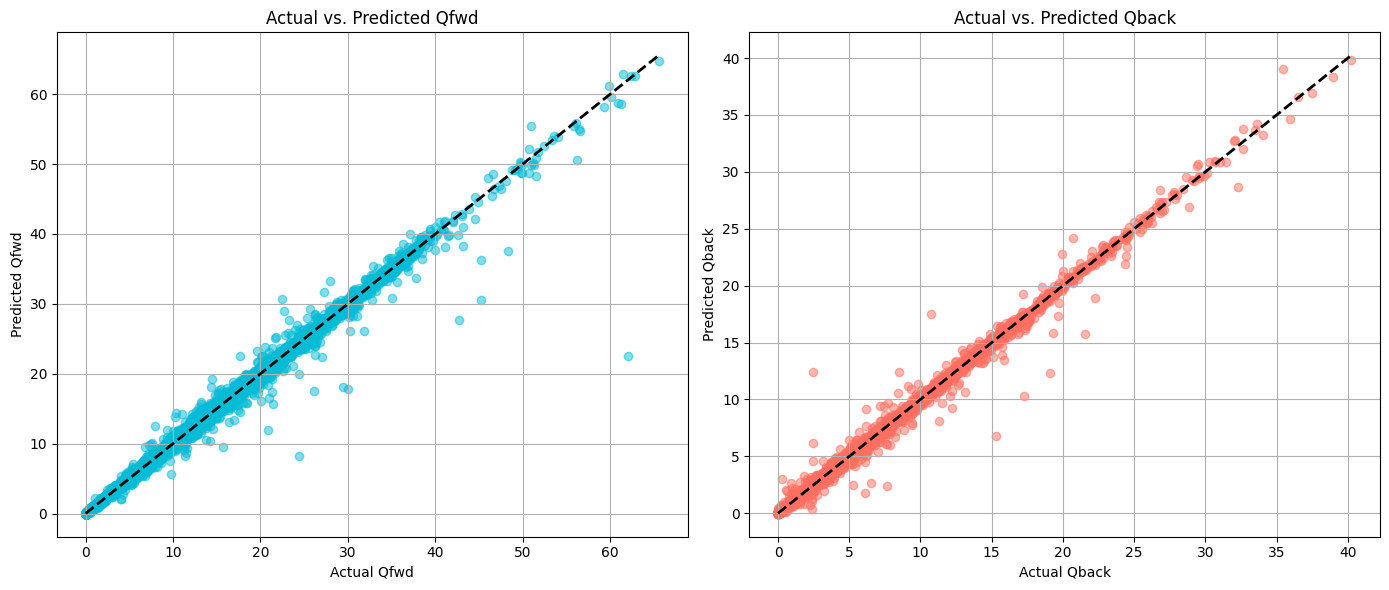

In [12]:
# Create a figure with two subplots for Qfwd and Qback
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for Qfwd
all_y_test = np.stack(df_test["Q_fwd"]).flatten()
all_y_pred = np.stack(df_test["Q_fwd_pred"]).flatten()

ax[0].scatter(all_y_test, all_y_pred, color="#06BBD6", alpha=0.5)
ax[0].plot(
    [all_y_test.min(), all_y_test.max()],
    [all_y_test.min(), all_y_test.max()],
    "k--",
    lw=2,
)
ax[0].set_xlabel("Actual Qfwd")
ax[0].set_ylabel("Predicted Qfwd")
ax[0].set_title("Actual vs. Predicted Qfwd")
ax[0].grid(True)

# Scatter plot for Qback
all_y_test = np.stack(df_test["Q_back"]).flatten()
all_y_pred = np.stack(df_test["Q_back_pred"]).flatten()

ax[1].scatter(all_y_test, all_y_pred, color="#FF6F61", alpha=0.5)
ax[1].plot(
    [all_y_test.min(), all_y_test.max()],
    [all_y_test.min(), all_y_test.max()],
    "k--",
    lw=2,
)
ax[1].set_xlabel("Actual Qback")
ax[1].set_ylabel("Predicted Qback")
ax[1].set_title("Actual vs. Predicted Qback")
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Forward statistics

In [13]:
# convert dataframe columns to numpy
qfwd_actual = np.stack(df_test["Q_fwd"])
qfwd_predicted = np.stack(df_test["Q_fwd_pred"])
qback_actual = np.stack(df_test["Q_back"])
qback_predicted = np.stack(df_test["Q_back_pred"])

# Calculate performance metrics for Qfwd
mse_Qfwd = np.abs(qfwd_actual - qfwd_predicted) ** 2
mae_Qfwd = np.abs(qfwd_actual - qfwd_predicted)
mse_Qback = np.abs(qback_actual - qback_predicted) ** 2
mae_Qback = np.abs(qback_actual - qback_predicted)

# Print the results
print(f"Test Set Performance for Qfwd:")
print(f"Mean Absolute Error (MAE): {mae_Qfwd.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qfwd.mean():.6f}")

print(f"\nTest Set Performance for Qback:")
print(f"Mean Absolute Error (MAE): {mae_Qback.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qback.mean():.6f}")

Test Set Performance for Qfwd:
Mean Absolute Error (MAE): 0.046812
Mean Squared Error (MSE): 0.037927

Test Set Performance for Qback:
Mean Absolute Error (MAE): 0.020196
Mean Squared Error (MSE): 0.007008


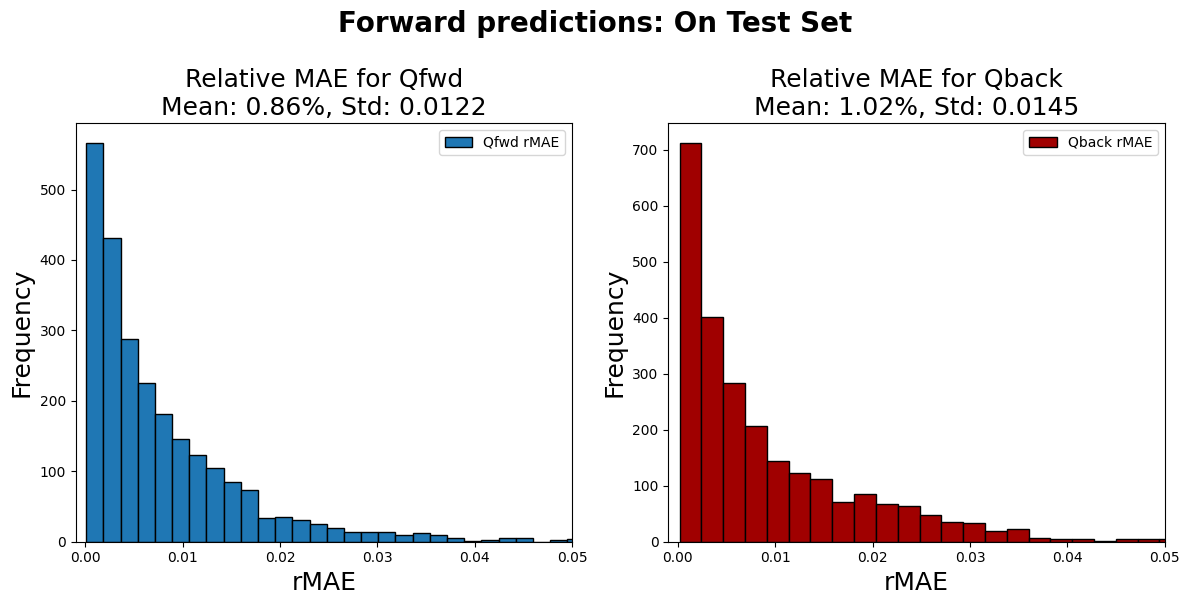

In [16]:
# absolute percentage error
mape_Qfwd = mae_Qfwd.mean(axis=1) / qfwd_actual.mean()
mape_Qback = mae_Qback.mean(axis=1) / qback_actual.mean()

# Plot histograms of MAE for Qfwd and Qback
plt.figure(figsize=(12, 6))
plt.suptitle("Forward predictions: On Test Set", fontweight="bold", fontsize=20, y=1.00)

# Plot the Qfwd MAE distribution
plt.subplot(1, 2, 1)
plt.hist(
    mape_Qfwd,
    bins=100,
    color="#1f77b4ff",
    label="Qfwd rMAE",
    edgecolor="black",
    alpha=1,
)
plt.title(
    f"Relative MAE for Qfwd\nMean: {100*mape_Qfwd.mean():.2f}%, Std: {mape_Qfwd.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.001, 0.05])

# Plot the Qback MAE distribution
plt.subplot(1, 2, 2)
plt.hist(
    mape_Qback,
    bins=100,
    color="#a00000ff",
    label="Qback rMAE",
    edgecolor="black",
    alpha=1,
)
plt.title(
    f"Relative MAE for Qback\nMean: {100*mape_Qback.mean():.2f}%, Std: {mape_Qback.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.001, 0.05])

plt.tight_layout()
plt.show()

### Testing Plot Predicted vs Mie
---

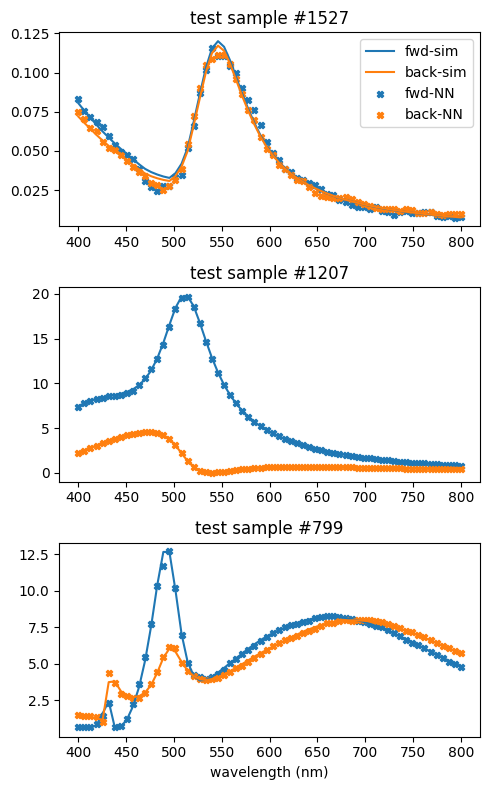

In [18]:
# Create a figure with subplots for the three configurations
plt.figure(figsize=(5, 8))
for i, d in enumerate(np.random.choice(len(df_test), 3)):
    plt.subplot(3, 1, i + 1, title=f"test sample #{d}")
    plt.plot(df_test["wavelength"][d], df_test["Q_fwd"][d], label="fwd-sim")
    plt.plot(df_test["wavelength"][d], df_test["Q_back"][d], label="back-sim")
    plt.scatter(
        df_test["wavelength"][d],
        df_test["Q_fwd_pred"][d],
        label="fwd-NN",
        marker="X",
        s=20,
    )
    plt.scatter(
        df_test["wavelength"][d],
        df_test["Q_back_pred"][d],
        label="back-NN",
        marker="X",
        s=20,
    )
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel("wavelength (nm)")

plt.tight_layout()
plt.show()